In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '/scratch/fivanovic/X-SH/T6-PDI/production_runs/analysis_scripts')
import file_parsers as FP
import xsh_analysis_functions as XSA

In [18]:
nuclear_timestep = 0.05
population_threshold = 0.95

simulation = 'physical_system_optical_retry/'
file_keyword = 'physopt_retry'

chosen_path = f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/{simulation}/analysis_arrays'

In [19]:
#loading in arrays which have the time-dependent populations of different diabat types, for each individual trajectory

total_XT_single_populations = np.loadtxt(chosen_path + f'/{file_keyword}_XT_individual_populations.txt')

CSS_single_populations = np.loadtxt(chosen_path + f'/{file_keyword}_CSS_individual_populations.txt')
INT_single_populations = np.loadtxt(chosen_path + f'/{file_keyword}_INT_individual_populations.txt')
#FS_single_populations = np.loadtxt(chosen_path + f'/{file_keyword}_FS_individual_populations.txt')

CT_single_populations = 1 - INT_single_populations - total_XT_single_populations - CSS_single_populations
total_CT_single_populations = CT_single_populations + INT_single_populations + CSS_single_populations
#CT_single_populations corresponds to CT-states that are neither interfacial nor charge-separated
#the total is therefore all of the CT-states' populations put together

In [20]:
exciton_single_IPR = np.loadtxt(chosen_path + f'/{file_keyword}_individual_exciton_IPR.txt')
electron_single_IPR = np.loadtxt(chosen_path + f'/{file_keyword}_individual_electron_IPR.txt')
hole_single_IPR = np.loadtxt(chosen_path + f'/{file_keyword}_individual_hole_IPR.txt')

exciton_single_locations = np.loadtxt(chosen_path + f'/{file_keyword}_individual_exciton_locations.txt')
electron_single_locations = np.loadtxt(chosen_path + f'/{file_keyword}_individual_electron_locations.txt')
hole_single_locations = np.loadtxt(chosen_path + f'/{file_keyword}_individual_hole_locations.txt')

time_nstep_intervals = np.arange(0, len(hole_single_IPR[0]))*nuclear_timestep*10

Text(0.5, 0.01, 'Simulation time /fs')

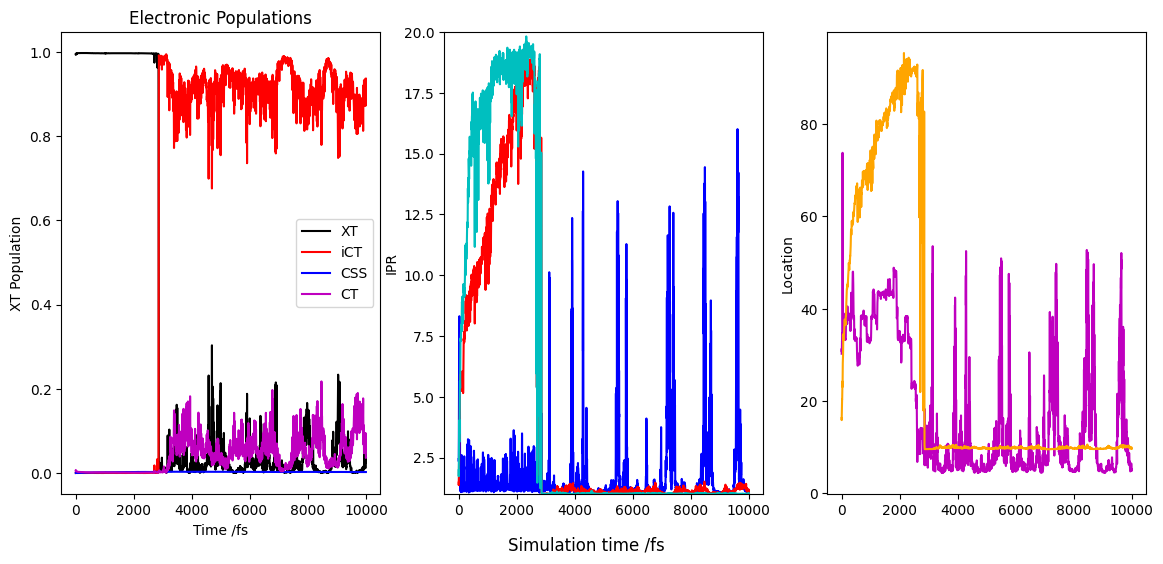

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (14, 6))

chosen_index = 269 #198 good traj e5 2xCT; 171 good traj for e3.5 2xCT; #2 good traj for physical system; #74/187 for e3.5 3xCT
#print(counter)
#counter += 1

#physopt 146 taken for psi-k animation

first_slice = 0
end_slice = -1

axs[0].plot(time_nstep_intervals[first_slice:end_slice], total_XT_single_populations[chosen_index][first_slice:end_slice], color='k', label='XT')
axs[0].plot(time_nstep_intervals[first_slice:end_slice], INT_single_populations[chosen_index][first_slice:end_slice], color='r', label='iCT')
axs[0].plot(time_nstep_intervals[first_slice:end_slice], CSS_single_populations[chosen_index][first_slice:end_slice], color='b', label='CSS')
#axs[0].plot(time_nstep_intervals[first_slice:end_slice], FS_single_populations[chosen_index][first_slice:end_slice], color='c')
axs[0].plot(time_nstep_intervals[first_slice:end_slice], CT_single_populations[chosen_index][first_slice:end_slice], color='m', label='CT')
axs[0].set_ylabel('XT Population')
axs[0].set_xlabel('Time /fs')
axs[0].set_title('Electronic Populations')
axs[0].legend(loc='best')

axs[1].plot(time_nstep_intervals[first_slice:end_slice], exciton_single_IPR[chosen_index][first_slice:end_slice], color='b')
axs[1].plot(time_nstep_intervals[first_slice:end_slice], electron_single_IPR[chosen_index][first_slice:end_slice], color='r')
axs[1].plot(time_nstep_intervals[first_slice:end_slice], hole_single_IPR[chosen_index][first_slice:end_slice], color='c')
axs[1].set_ylabel('IPR')
axs[1].set_ylim([1,20])

axs[2].plot(time_nstep_intervals[first_slice:end_slice], exciton_single_locations[chosen_index][first_slice:end_slice] - 92, color='m')
axs[2].plot(time_nstep_intervals[first_slice:end_slice], electron_single_locations[chosen_index][first_slice:end_slice] - hole_single_locations[chosen_index][first_slice:end_slice], color='orange')
axs[2].set_ylabel('Location')

fig.supxlabel('Simulation time /fs')

In [22]:
def find_dissociation_index(iterable, population_threshold, post_dissoc_elements, post_dissoc_buffer):

    for outer_index in range(len(iterable)):

        if iterable[outer_index] < population_threshold:

            for inner_val in iterable[outer_index: outer_index + post_dissoc_elements]:

                if inner_val > population_threshold + post_dissoc_buffer:
                    
                    fluctuation = True
                    break

                else:
                    fluctuation = False

            if not fluctuation:

                return outer_index
            
    return None

In [23]:
def XT_dissociation_properties(populations, exciton_IPR, electron_IPR, hole_IPR, exciton_locs, electron_locs, hole_locs, simulation_time):

    exciton_dIPR_list = []
    exciton_dloc_list = []

    electron_dIPR_list = []
    electron_dloc_list = []

    hole_dIPR_list = []
    hole_dloc_list = []

    dissoc_time_list = []

    for index, row in enumerate(populations):

        dissoc_CT_index = find_dissociation_index(row, 0.05, 1000, 0.05)

        if np.any(dissoc_CT_index):

            #dissoc_CT_index = np.min(dissoc_CT_indices)
            truncated_row = row[:dissoc_CT_index]

            dissoc_XT_indices = np.where(truncated_row > 0.95)

            if np.any(dissoc_XT_indices):

                dissoc_XT_index = np.max(dissoc_XT_indices)

                dissoc_exciton_IPR = exciton_IPR[index][dissoc_XT_index]
                exciton_dIPR_list.append(dissoc_exciton_IPR)
                dissoc_exciton_loc = exciton_locs[index][dissoc_XT_index]
                exciton_dloc_list.append(dissoc_exciton_loc)

                dissoc_electron_IPR = electron_IPR[index][dissoc_CT_index]
                electron_dIPR_list.append(dissoc_electron_IPR)
                dissoc_electron_loc = electron_locs[index][dissoc_CT_index]
                electron_dloc_list.append(dissoc_electron_loc)


                dissoc_hole_IPR = hole_IPR[index][dissoc_CT_index]
                hole_dIPR_list.append(dissoc_hole_IPR)
                dissoc_hole_loc = hole_locs[index][dissoc_CT_index]
                hole_dloc_list.append(dissoc_hole_loc)

                dissoc_time = simulation_time[dissoc_XT_index]
                dissoc_time_list.append(dissoc_time)
            
            else:
                continue
        
        else:
            continue

    observable_array = np.zeros((len(exciton_dIPR_list), 7))

    observable_array[:,0] = np.array(dissoc_time_list)
    observable_array[:,1] = np.array(exciton_dIPR_list)
    observable_array[:,2] = np.array(electron_dIPR_list)
    observable_array[:,3] = np.array(hole_dIPR_list)
    observable_array[:,4] = np.array(exciton_dloc_list)
    observable_array[:,5] = np.array(electron_dloc_list)
    observable_array[:,6] = np.array(hole_dloc_list)

    return observable_array

In [24]:
def prepare_bins(x_vals, y_vals, number_bins):

    bin_increment = (np.max(x_vals) - np.min(x_vals))/number_bins
    x_bins = np.arange(np.min(x_vals), np.max(x_vals) + bin_increment, bin_increment)

    avg_y_vals = []

    for index in range(1,len(x_bins)):

        bin_indices = np.where(x_vals < x_bins[index])[0]
        x_vals_under = x_vals[bin_indices]
        y_vals_under = y_vals[bin_indices]

        bin_indices = np.where(x_vals_under >= x_bins[index-1])[0]
        y_vals_binned = y_vals_under[bin_indices]

        if np.any(y_vals_binned):
            avg_y_vals.append(np.mean(y_vals_binned))
        else:
            avg_y_vals.append(0)

    xbin_midpoints = (x_bins[:-1] + x_bins[1:])/2

    return xbin_midpoints, avg_y_vals

In [32]:
dissociation_property_array = XT_dissociation_properties(total_XT_single_populations, exciton_single_IPR, electron_single_IPR, hole_single_IPR, exciton_single_locations, electron_single_locations, hole_single_locations, time_nstep_intervals)

In [ ]:
#XT_dissociation_indices = get_XT_dissociation_indices(total_XT_single_populations)

XT_CT_threshold = 0.95
CSS_iCT_threshold = 0.8

all_pathways = []
#defining list that will contain the pathways of all trajectories

for index in range(len(total_XT_single_populations)):

    XT_dissociation_index = find_dissociation_index(total_XT_single_populations[index], 0.05, 1000, 0.50)
    #possibly ignoring pathways that begin as hybrid states here, might be why total CS yield of e10 system is larger than sum of cold and hot pathway rates
    if not XT_dissociation_index: continue

    truncated_row = total_XT_single_populations[index][:XT_dissociation_index]
    full_XT_indices = np.where(truncated_row > 0.95)
    if not np.any(full_XT_indices): continue

    pathway = []
    condensed_pathway = []

    for frame in range(len(CSS_single_populations[index])):

        #for each printed timestep in the simulation, we categorise the wvaefunction into different types of electronic state,
        #depending on which type of diabat dominates the electronic wavefunction

        if CSS_single_populations[index][frame] > CSS_iCT_threshold:
            pathway.append('CSS')
            #e.g. if CSS diabats make up 80% of the wavefunction, then we label this timestep 'CSS', and we do this
            #for the other diabat types

        elif (INT_single_populations[index][frame]) > CSS_iCT_threshold:
            pathway.append('iCT')
        elif total_CT_single_populations[index][frame] > XT_CT_threshold:
            pathway.append('CT')
        elif total_XT_single_populations[index][frame] > XT_CT_threshold:
            pathway.append('XT')

        else:

            pathway.append('H')

    condensed_pathway.append(pathway[0])
    for index2 in range(1, len(pathway)):
        #printing each timestep's wavefunction character is too complicated, so we just print the instances where they
        #change, to see how the carriers change throughout the simulation
        
        if pathway[index2] != pathway[index2 - 1]:
            condensed_pathway.append(pathway[index2])

    all_pathways.append(condensed_pathway)
    #then append this abridged pathway to the list of all trajectories' pathways


#many of these trajectories actually oscillate between two state types before doing anything. We want to simplify this so
#it is easy to categorise the different pathways. Currently, a pathway that decays to iCT through XT --> H will be unique from
#all other instances if it flits between XT and H an arbitrary number of times, but we mostly care about how the exciton dissociates
    
#fluctuation_counter = 0
for index3 in range(len(all_pathways)):

    p = all_pathways[index3]
    fluctuation_keyword = False

    if (p.count('XT') > 1):
        #remove XT oscillating with other states before dissociating

        reversed_p = list(reversed(p))
        reversed_XT_index = reversed_p.index('XT')
        #find final occurence of XT

        final_XT_index = -reversed_XT_index - 1
        abridged_p = p[final_XT_index:]
        leftover_p = p[:final_XT_index]

        #if (leftover_p.count('iCT') > 0):
        #    fluctuation_counter += 1
        #    abridged_p = ['XT','H','iCT','H'] + abridged_p
        #    fluctuation_keyword = True

        #elif (leftover_p.count('CT') > 0):
        #    fluctuation_counter += 1
        #    abridged_p = ['XT','H','CT','H'] + abridged_p
        #    fluctuation_keyword = True

        p = abridged_p[:]

        #remove all elements before this occurence. Essentially, if a simulation begins in XT, we don't care about anything it
        #does before the exciton irreversibly dissociates

    if p[-1] == 'CSS':
        #remove CSS oscillations with other CT-state types

        CSS_index = p.index('CSS')
        #find first CSS instance

        p = p[:CSS_index+1] #+ [p[-1]]
        #remove all elements after this, we assume all charges are swept away by field once they reach the CSS

    if p[-1] == 'iCT':

        iCT_index = p.index('iCT') #find index of first iCT instance
        p = p[:iCT_index+1] #remove all elements after this to remove irrelevant fluctuations, and we know the traj. ends in the same state

    if p[-1] == 'CT':

        CT_index = p.index('CT')
        p = p[:CT_index+1] #removing all fluctuations after first non-interfacial CT occurrance

    all_pathways[index3] = p

thermal_generation_indices = []
hot_generation_indices = []
final_CT_indices = []
final_iCT_indices = []

for index4 in range(len(all_pathways)):

    single_pathway = all_pathways[index4]

    if single_pathway[-1] == 'CSS':

        if 'iCT' in single_pathway:
            thermal_generation_indices.append(index4)
        elif 'CT' in single_pathway:
            hot_generation_indices.append(index4)
        else:
            hot_generation_indices.append(index4)

    elif single_pathway[-1] == 'CT':
        final_CT_indices.append(index4)
    
    elif single_pathway[-1] == 'iCT':
        final_iCT_indices.append(index4)

320


In [27]:
thermal_generation_indices = np.array(thermal_generation_indices)
hot_generation_indices = np.array(hot_generation_indices)
final_CT_indices = np.array(final_CT_indices)
final_iCT_indices = np.array(final_iCT_indices)

#file_keyword = 'e10'

np.savetxt(f'saved_wf_processing/dissociation_info/{simulation}/{file_keyword}_all_dissociation_distances.txt', dissociation_property_array[:,4])
np.savetxt(f'saved_wf_processing/dissociation_info/{simulation}/{file_keyword}_all_dissociation_eh_distances.txt', dissociation_property_array[:,5]-dissociation_property_array[:,6])

np.savetxt(f'saved_wf_processing/dissociation_info/{simulation}/{file_keyword}_iCT_dissociation_distances.txt', dissociation_property_array[:,4][final_iCT_indices])
np.savetxt(f'saved_wf_processing/dissociation_info/{simulation}/{file_keyword}_CT_dissociation_distances.txt', dissociation_property_array[:,4][final_CT_indices])
#np.savetxt(f'saved_wf_processing/dissociation_info/{simulation}/{file_keyword}_tGen_dissociation_distances.txt', dissociation_property_array[:,4][thermal_generation_indices])
#np.savetxt(f'saved_wf_processing/dissociation_info/{simulation}/{file_keyword}_hGen_dissociation_distances.txt', dissociation_property_array[:,4][hot_generation_indices])

In [15]:
def plot_dissociation_distribution_nostack(ax_object, path, simulation, file_keyword, state_list, colour_list, label_list, shading_list, width_list):

    for index in range(len(state_list)):

        try:
            info_array = np.loadtxt(path + f'{simulation}/{file_keyword}_{state_list[index]}_dissociation_distances.txt')
            ax_object.hist(info_array - 92, color = f'{colour_list[index]}', rwidth=width_list[index], alpha=shading_list[index], label=f'{label_list[index]}', bins = np.arange(5,105,10), stacked=True)

        except:
            continue

In [42]:
def plot_dissociation_distribution(ax_object, path, simulation, file_keyword, state_list, colour_list, label_list, shading_list, width_list):

    info_array_list = []
    used_colour_list = []

    for index in range(len(state_list)):

        try:
            info_array = np.loadtxt(path + f'{simulation}/{file_keyword}_{state_list[index]}_dissociation_distances.txt')
            info_array_list.append(info_array-92)
            used_colour_list.append(f'{colour_list[index]}')

        except:
            continue

    ax_object.hist(info_array_list, bins=np.array([0,35,65,95]), stacked=True, color=used_colour_list, alpha=0.8, rwidth=0.9, label=label_list)

Text(0.5, 0.06, 'Exciton Dissociation Distance (Å)')

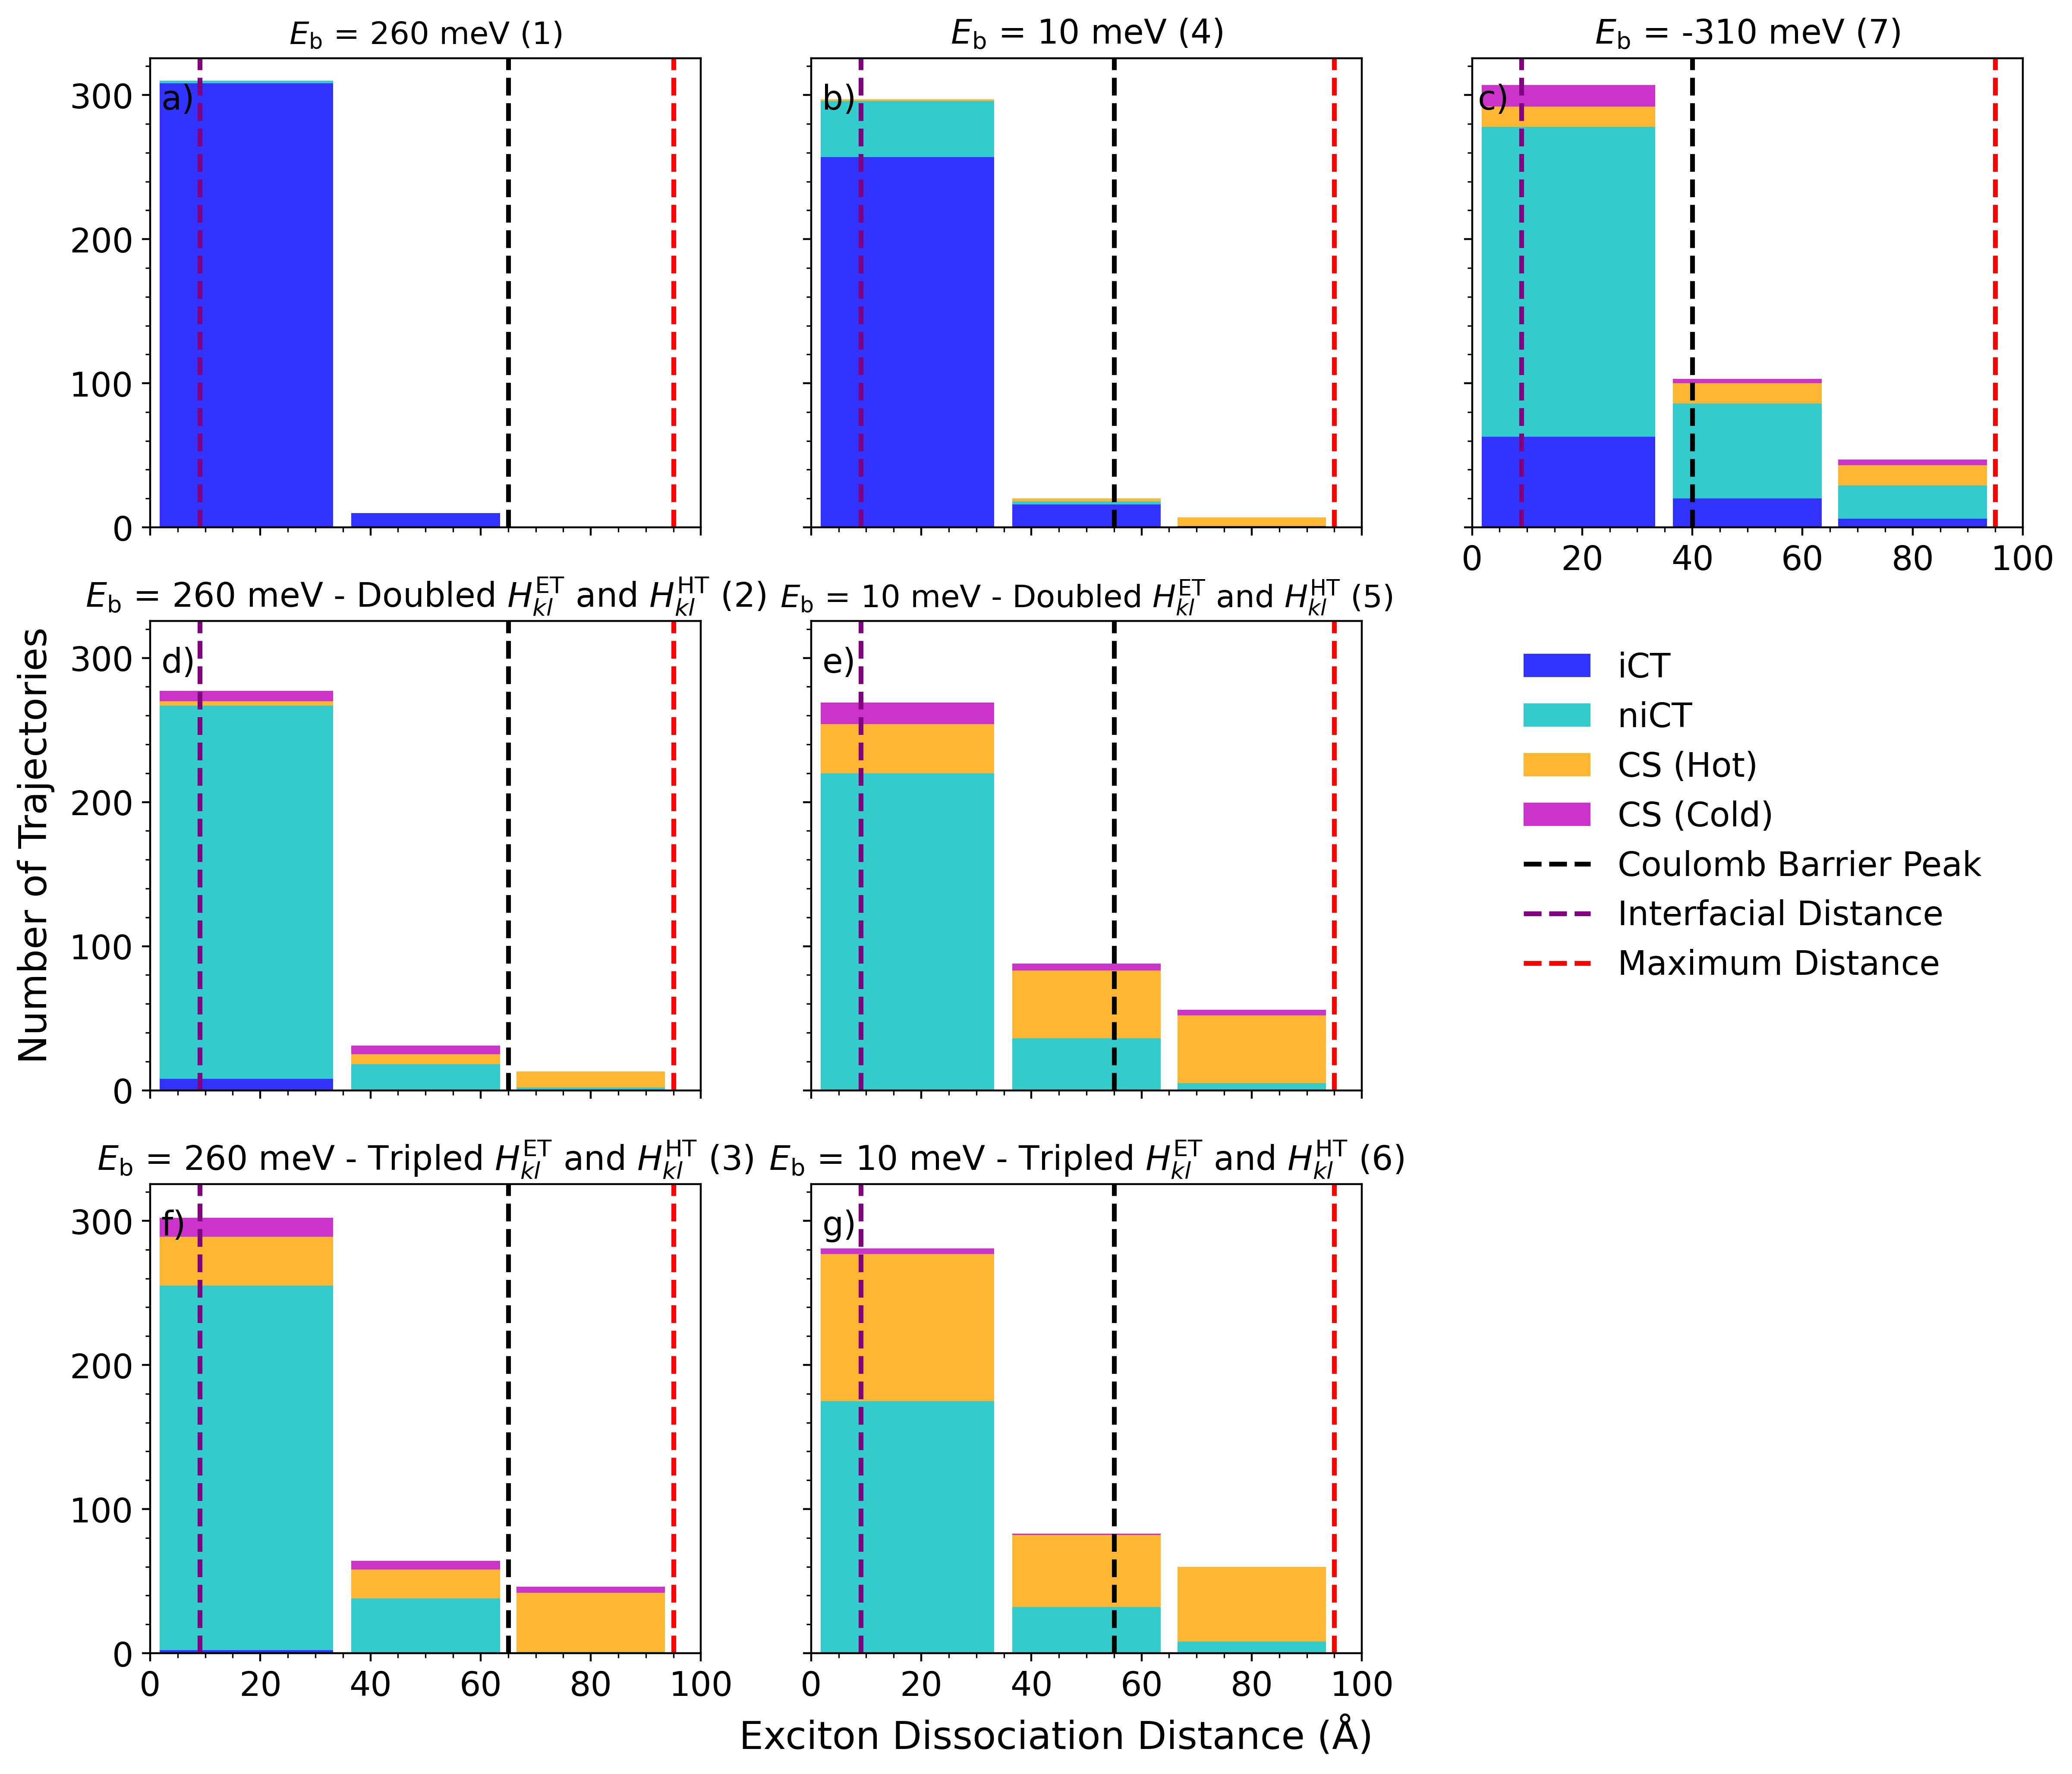

In [44]:
path = 'saved_wf_processing/dissociation_info/'
state_list = ['iCT', 'CT', 'hGen', 'tGen']
label_list = ['iCT', 'niCT', 'CS (Hot)', 'CS (Cold)']
colour_list = ['b', 'c', 'orange', 'm']
shading_list = [0.80, 0.80, 0.80, 0.90]
width_list = [0.90, 0.78, 0.70, 0.55]

fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(14,12), sharey=True, rasterized=True, dpi=400)

plot_dissociation_distribution(axs[0,0], path, 'physical_system_optical_retry', 'physopt_retry', state_list, colour_list, label_list, shading_list, width_list)
axs[0,0].set_xticklabels([])
axs[0,0].yaxis.set_tick_params(labelsize = 14)
axs[0,0].minorticks_on()
axs[0,0].set_title('$E_\mathrm{b}$ = 260 meV (1)', fontsize=13)
axs[0,0].axvline(65, linewidth=2, color='k', linestyle='--', label='Coulomb Barrier Peak')
axs[0,0].axvline(9, linewidth=2, color='purple', linestyle='--', label='Interfacial Distance')
axs[0,0].axvline(95, linewidth=2, color='r', linestyle='--', label='Maximum Distance')
axs[0,0].set_xlim([0,100])
axs[0,0].text(2,290,'a)', fontsize=14)

plot_dissociation_distribution(axs[0,1], path, 'epsilon5_offset0.4', 'e5', state_list, colour_list, label_list, shading_list, width_list)
axs[0,1].set_title('$E_\mathrm{b}$ = 10 meV (4)', fontsize=14)
axs[0,1].set_xticklabels([])
axs[0,1].yaxis.set_tick_params(labelsize = 14)
axs[0,1].minorticks_on()
axs[0,1].axvline(55, linewidth=2, color='k', linestyle='--', label='Coulomb Barrier Peak')
axs[0,1].axvline(9, linewidth=2, color='purple', linestyle='--', label='Interfacial Distance')
axs[0,1].axvline(95, linewidth=2, color='r', linestyle='--', label='Maximum Distance')
axs[0,1].set_xlim([0,100])
axs[0,1].text(2,290,'b)', fontsize=14)

plot_dissociation_distribution(axs[0,2], path, 'epsilon10_offset0.4', 'e10', state_list, colour_list, label_list, shading_list, width_list)
axs[0,2].set_title('$E_\mathrm{b}$ = -310 meV (7)', fontsize=14)
axs[0,2].xaxis.set_tick_params(labelsize = 14)
axs[0,2].minorticks_on()
axs[0,2].axvline(40, linewidth=2, color='k', linestyle='--', label='Coulomb Barrier Peak')
axs[0,2].axvline(9, linewidth=2, color='purple', linestyle='--', label='Interfacial Distance')
axs[0,2].axvline(95, linewidth=2, color='r', linestyle='--', label='Maximum Distance')
axs[0,2].legend(fontsize=14, bbox_to_anchor=(0.98, -0.2), frameon=False)
axs[0,2].set_xlim([0,100])
axs[0,2].text(1,290,'c)', fontsize=14)

plot_dissociation_distribution(axs[1,1], path, 'epsilon5_2xCTcoup', 'e5_2xCT', state_list, colour_list, label_list, shading_list, width_list)
axs[1,1].set_title(r'$E_\mathrm{b}$ = 10 meV - Doubled $H^{\mathrm{ET}}_{kl}$ and $H^{\mathrm{HT}}_{kl}$ (5)', fontsize=13)
axs[1,1].set_xticklabels([])
axs[1,1].yaxis.set_tick_params(labelsize = 14)
axs[1,1].minorticks_on()
axs[1,1].axvline(55, linewidth=2, color='k', linestyle='--', label='Coulomb Barrier Peak')
axs[1,1].axvline(9, linewidth=2, color='purple', linestyle='--', label='Interfacial Distance')
axs[1,1].axvline(95, linewidth=2, color='r', linestyle='--', label='Maximum Distance')
axs[1,1].set_xlim([0,100])
axs[1,1].text(2,290,'e)', fontsize=14)

plot_dissociation_distribution(axs[2,1], path, 'epsilon5_3xCTcoup', 'e5_3xCT', state_list, colour_list, label_list, shading_list, width_list)
axs[2,1].set_title(r'$E_\mathrm{b}$ = 10 meV - Tripled $H^{\mathrm{ET}}_{kl}$ and $H^{\mathrm{HT}}_{kl}$ (6)', fontsize=14)
axs[2,1].yaxis.set_tick_params(labelsize = 14)
axs[2,1].xaxis.set_tick_params(labelsize = 14)
axs[2,1].minorticks_on()
axs[2,1].axvline(55, linewidth=2, color='k', linestyle='--', label='Coulomb Barrier Peak')
axs[2,1].axvline(9, linewidth=2, color='purple', linestyle='--', label='Interfacial Distance')
axs[2,1].axvline(95, linewidth=2, color='r', linestyle='--', label='Maximum Distance')
axs[2,1].set_xlim([0,100])
axs[2,1].text(2,290,'g)', fontsize=14)

plot_dissociation_distribution(axs[1,0], path, 'epsilon3.5_2xCTcoup', 'e3.5_2xCT', state_list, colour_list, label_list, shading_list, width_list)
axs[1,0].set_title(r'$E_\mathrm{b}$ = 260 meV - Doubled $H^{\mathrm{ET}}_{kl}$ and $H^{\mathrm{HT}}_{kl}$ (2)', fontsize=14)
axs[1,0].set_xticklabels([])
axs[1,0].yaxis.set_tick_params(labelsize = 14)
axs[1,0].minorticks_on()
axs[1,0].axvline(65, linewidth=2, color='k', linestyle='--', label='Coulomb Barrier Peak')
axs[1,0].axvline(9, linewidth=2, color='purple', linestyle='--', label='Interfacial Distance')
axs[1,0].axvline(95, linewidth=2, color='r', linestyle='--', label='Maximum Distance')
axs[1,0].set_xlim([0,100])
axs[1,0].text(2,290,'d)', fontsize=14)

plot_dissociation_distribution(axs[2,0], path, 'epsilon3.5_3xCTcoup', 'e3.5_3xCT', state_list, colour_list, label_list, shading_list, width_list)
axs[2,0].set_title(r'$E_\mathrm{b}$ = 260 meV - Tripled $H^{\mathrm{ET}}_{kl}$ and $H^{\mathrm{HT}}_{kl}$ (3)', fontsize=14)
axs[2,0].yaxis.set_tick_params(labelsize = 14)
axs[2,0].xaxis.set_tick_params(labelsize = 14)
axs[2,0].minorticks_on()
axs[2,0].axvline(65, linewidth=2, color='k', linestyle='--', label='Coulomb Barrier Peak')
axs[2,0].axvline(9, linewidth=2, color='purple', linestyle='--', label='Interfacial Distance')
axs[2,0].axvline(95, linewidth=2, color='r', linestyle='--', label='Maximum Distance')
axs[2,0].set_xlim([0,100])
axs[2,0].text(2,290,'f)', fontsize=14)

axs[1,-1].axis('off')
axs[2,-1].axis('off')

fig.supylabel('Number of Trajectories', x=0.07, fontsize=16)
fig.supxlabel('Exciton Dissociation Distance (\u212B)', y = 0.06, fontsize=16)

In [5]:
def plot_dissociation_scatter(ax_object, path, simulation, file_keyword, colour, label, shading):

    distance_array = np.loadtxt(path + f'{simulation}/{file_keyword}_all_dissociation_distances.txt')
    eh_distance_array = np.loadtxt(path + f'{simulation}/{file_keyword}_all_dissociation_eh_distances.txt')

    ax_object.scatter(distance_array-92, eh_distance_array, color=colour, label=label, s=3.5, alpha=shading)

FileNotFoundError: saved_wf_processing/dissociation_info/physical_system_optical_retry/physopt_retry_all_dissociation_eh_distances.txt not found.

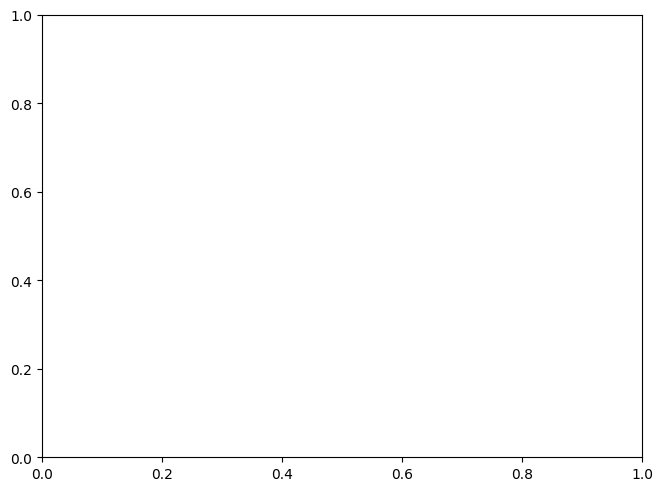

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7.75,5.75))

plot_dissociation_scatter(ax, path, 'physical_system_optical_retry', 'physopt_retry', 'b', 'High E$_b$', 1)
plot_dissociation_scatter(ax, path, 'epsilon3.5_3xCTcoup', 'e3.5_3xCT', 'orange', 'High E$_b$ - 3x CT-coupling', 0.8)
plot_dissociation_scatter(ax, path, 'epsilon10_offset0.4', 'e10', 'm', 'Low E$_b$', 0.65)
plot_dissociation_scatter(ax, path, 'physical_system_optical', 'physopt', 'b', None, 1)
ax.set_ylabel('Electron-hole distance /\u212B', fontsize=14)
ax.set_xlabel('Exciton distance /\u212B', fontsize=14)
ax.set_ylim([0,200])
ax.set_xlim([0,100])
ax.legend(loc='upper left', fontsize=12)
ax.minorticks_on()
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

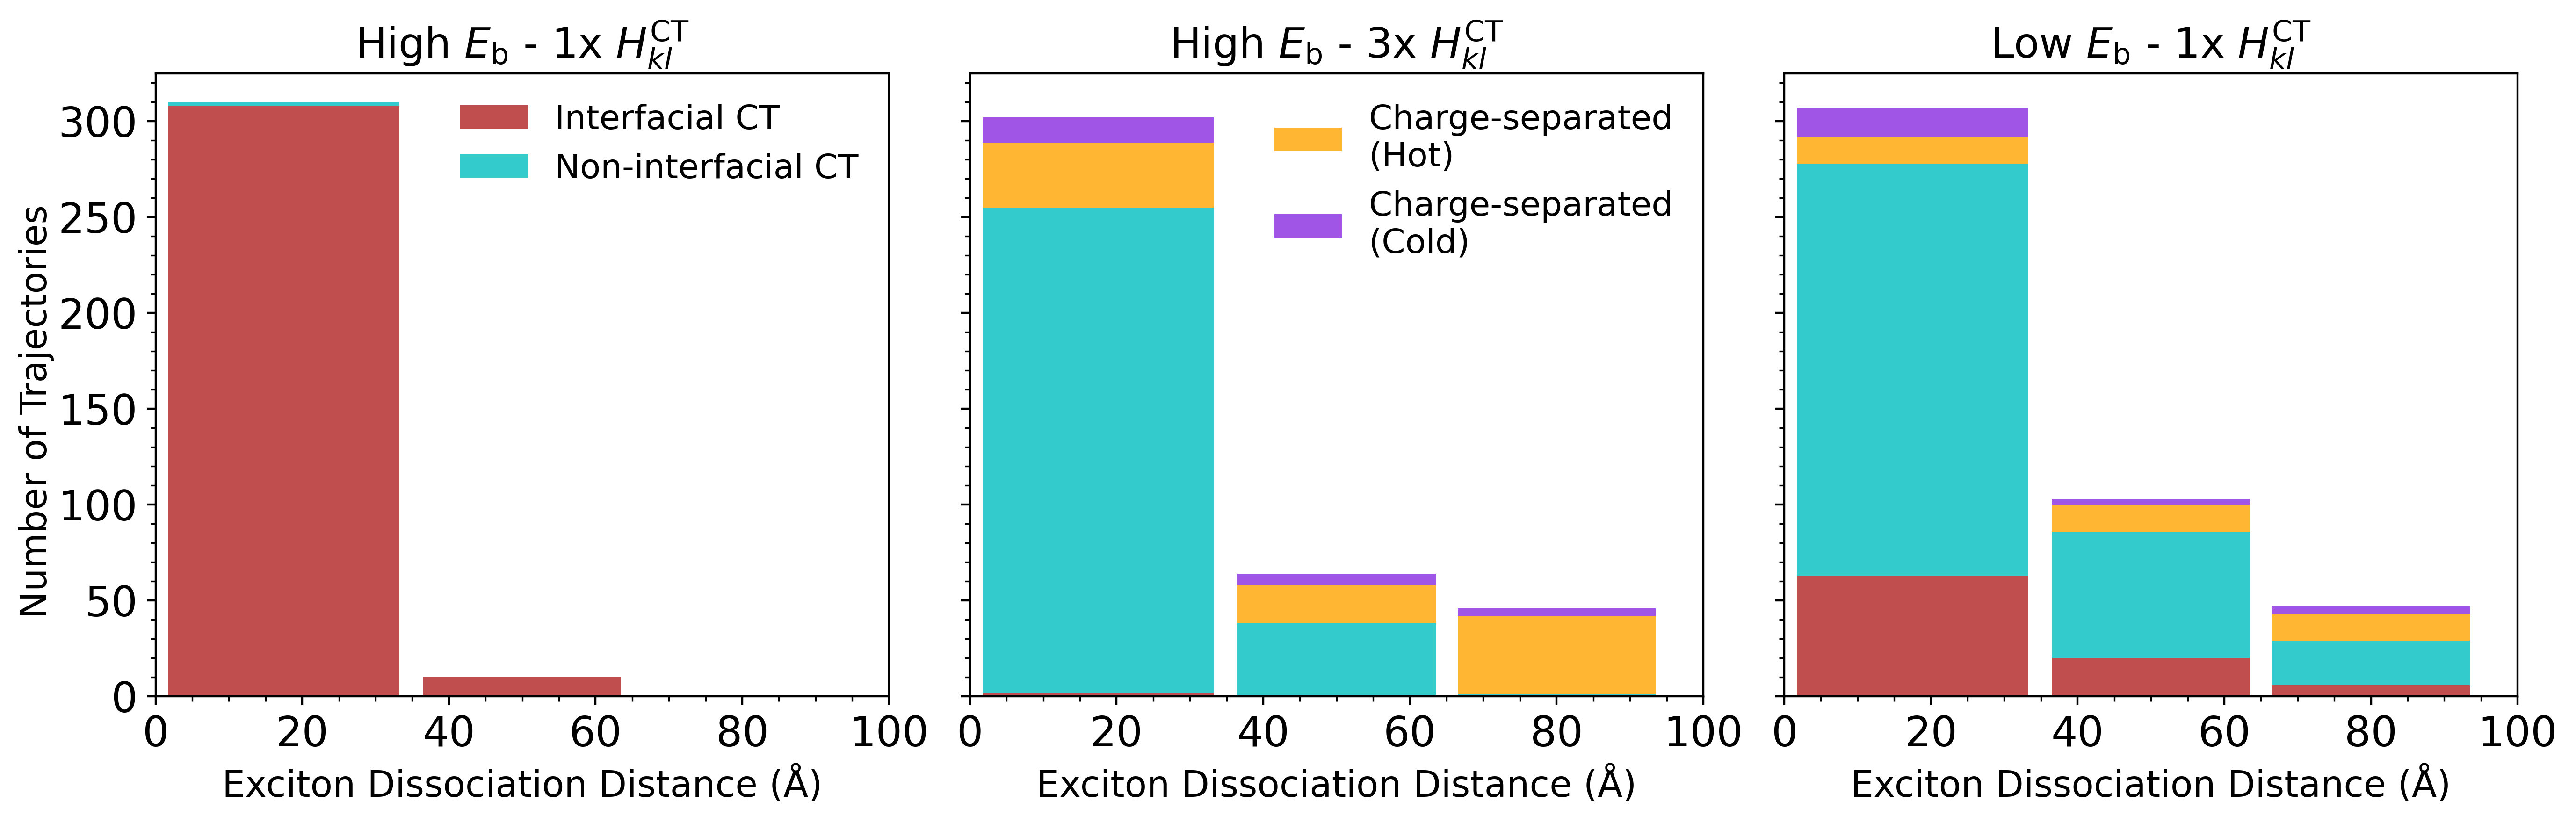

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4.5), sharey=True, rasterized=True, dpi=400)

path = 'saved_wf_processing/dissociation_info/'
state_list = ['iCT', 'CT', 'hGen', 'tGen']
label_list = ['Interfacial CT', 'Non-interfacial CT', 'Charge-separated' + '\n' + '(Hot)', 'Charge-separated' + '\n' + '(Cold)']
colour_list = ['firebrick', 'c', 'orange', 'blueviolet']
shading_list = [0.80, 0.80, 0.60, 0.90]
width_list = [0.90, 0.78, 0.70, 0.55]

plot_dissociation_distribution(axs[0], path, 'physical_system_optical_retry', 'physopt_retry', state_list, colour_list, [label_list[0], label_list[1], '_nolegend_', '_nolegend_', '_nolegend_'], shading_list, width_list)
axs[0].yaxis.set_tick_params(labelsize = 16)
axs[0].xaxis.set_tick_params(labelsize = 16)
axs[0].minorticks_on()
axs[0].set_title(r'High $E_\mathrm{b}$ - 1x $H^{\mathrm{CT}}_{kl}$', fontsize=16)
axs[0].legend(frameon=False, loc='upper right', fontsize=13)
axs[0].set_xlim([0,100])
axs[0].set_ylim([0,325])
axs[0].set_xlabel('Exciton Dissociation Distance (\u212B)', fontsize=14)

plot_dissociation_distribution(axs[1], path, 'epsilon3.5_3xCTcoup', 'e3.5_3xCT', state_list, colour_list, ['_nolegend_', '_nolegend_', label_list[2], label_list[3]], shading_list, width_list)
axs[1].yaxis.set_tick_params(labelsize = 16)
axs[1].xaxis.set_tick_params(labelsize = 16)
axs[1].minorticks_on()
axs[1].set_xlim([0,100])
axs[1].set_title(r'High $E_\mathrm{b}$ - 3x $H^{\mathrm{CT}}_{kl}$', fontsize=16)
axs[1].set_xlabel('Exciton Dissociation Distance (\u212B)', fontsize=14)
axs[1].legend(loc='upper right', fontsize=13, frameon=False)

plot_dissociation_distribution(axs[2], path, 'epsilon10_offset0.4', 'e10', state_list, colour_list, ['_nolegend_', '_nolegend_', label_list[2], label_list[3]], shading_list, width_list)
axs[2].xaxis.set_tick_params(labelsize = 16)
axs[2].minorticks_on()
axs[2].set_xlim([0,100])
axs[2].set_title(r'Low $E_\mathrm{b}$ - 1x $H^{\mathrm{CT}}_{kl}$', fontsize=16)
axs[2].set_xlabel('Exciton Dissociation Distance (\u212B)', fontsize=14)

fig.supylabel('Number of Trajectories', fontsize=14)
fig.tight_layout()